In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from colicoords import load, Cell, CellPlot
from colicoords.fitting import CellFit
import os
import rmsd
from tqdm.auto import tqdm

In [1]:
def rf():
    return np.random.rand(), np.random.rand()

In [4]:
res = [rf() for i in range(10)]
res

[(0.721208364232356, 0.5278365988282732),
 (0.4131659442123541, 0.03296103744677248),
 (0.7648325173244825, 0.07478453455805756),
 (0.5584223367402571, 0.08410337676476975),
 (0.3385373608151362, 0.08664033581720199),
 (0.936184698272645, 0.8703909694472902),
 (0.8637007275037136, 0.3883805511840498),
 (0.22601407952860864, 0.5599979572008066),
 (0.5813723733507554, 0.026655395693379602),
 (0.19025267639299936, 0.21002833792727904)]

In [5]:
np.array(res)

array([[0.72120836, 0.5278366 ],
       [0.41316594, 0.03296104],
       [0.76483252, 0.07478453],
       [0.55842234, 0.08410338],
       [0.33853736, 0.08664034],
       [0.9361847 , 0.87039097],
       [0.86370073, 0.38838055],
       [0.22601408, 0.55999796],
       [0.58137237, 0.0266554 ],
       [0.19025268, 0.21002834]])

In [6]:
data_dir = r'D:\Projects\CC_paper\figure_6_v3'

In [21]:
#https://github.com/charnley/rmsd/blob/master/rmsd/calculate_rmsd.py
def kabsch(P, Q):
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return U

In [88]:
m_cells = load(os.path.join(data_dir, 'cell_obj', 'm_cells_ph_10000_filtered_brightfield.hdf5'))

In [8]:
m_names = np.genfromtxt(os.path.join(data_dir, 'matched_names', 'm_cells_ph_10000_match_filter.txt'), dtype=str)

In [9]:
m_index = np.searchsorted(m_cells.name, m_names)
m_sorted = m_cells[m_index]
len(m_sorted)

7177

In [11]:
gt_cells = load(os.path.join(data_dir, 'cell_obj', 'cells_final_selected.hdf5'))

In [12]:
gt_names = np.genfromtxt(os.path.join(data_dir, 'matched_names', 'gt_cells_ph_10000_match_filter.txt'), dtype=str)
gt_index = np.searchsorted(gt_cells.name, gt_names)
gt_sorted = gt_cells[gt_index]

In [14]:
gt_sorted[0].data.shape, m_sorted[0].data.shape

((59, 90), (34, 64))

In [17]:
mc, gc = m_sorted[0], gt_sorted[0]

In [28]:
h = (59-35)/2
v = (90-64)/2

In [15]:
mc = m_sorted[0]
gc = gt_sorted[0]

P = np.stack([mc.data.data_dict['storm_inner']['x'], mc.data.data_dict['storm_inner']['y']]).T
Q = np.stack([gc.data.data_dict['storm_inner']['x'], gc.data.data_dict['storm_inner']['y']]).T

x = np.linspace(mc.coords.xl, mc.coords.xr, num=1000, endpoint=True)
T = np.stack((x, mc.coords.p(x))).T

P_mean = np.mean(P, axis=0)
Q_mean = np.mean(Q, axis=0)

Pt = P - P_mean
Qt = Q - Q_mean

U = kabsch(Pt, Qt)

Tt = T - P_mean
Tr = np.dot(Tt, U)

Pr = np.dot(Pt, U)
Prt = Pr + Q_mean
Trt = Tr + Q_mean


In [43]:
def transform_coords(gt_cell, m_cell):
    """uses kabsch to find the translation of storm localizations from m_cell onto gt_cell, then applies this transformation
    to the midline polynomial and fits the result to a polynomial to obtain tranformed coords
    """
    P = np.stack([m_cell.data.data_dict['storm_inner']['x'], m_cell.data.data_dict['storm_inner']['y']]).T
    Q = np.stack([gt_cell.data.data_dict['storm_inner']['x'], gt_cell.data.data_dict['storm_inner']['y']]).T
    
    assert P.shape == Q.shape

    x = np.linspace(m_cell.coords.xl, m_cell.coords.xr, num=1000, endpoint=True)
    T = np.stack((x, m_cell.coords.p(x))).T

    P_mean = np.mean(P, axis=0)
    Q_mean = np.mean(Q, axis=0)

    Pt = P - P_mean
    Qt = Q - Q_mean

    U = kabsch(Pt, Qt)

    Tt = T - P_mean
    Tr = np.dot(Tt, U)

    Pr = np.dot(Pt, U)
    Prt = Pr + Q_mean
    Trt = Tr + Q_mean
       
    xl = Trt.T[0].min()
    xr = Trt.T[0].max()
    r = m_cell.coords.r
    
    a0, a1, a2 = np.polyfit(Trt.T[0], Trt.T[1], 2)[::-1]
    
    d = {'a0': a0, 'a1': a1, 'a2': a2, 'xl': xl, 'xr':xr, 'r':r}
    
    return d
    

In [45]:
gc = gt_sorted[10].copy()
mc = m_sorted[10].copy()

In [17]:
d1 = transform_coords(gc, mc)

In [24]:
def cell_to_dict(cell):
    return {attr: getattr(cell.coords, attr) for attr in ['a0', 'a1', 'a2', 'r', 'xl', 'xr']}

In [60]:
def get_value(gt_cell, m_cell, data_name):
    d_m = transform_coords(gt_cell, m_cell)
    d_g = cell_to_dict(gt_cell)
    
    
    if data_name =='storm_inner':
        d_g['r'] /= (1.5554007217841803 * 1.314602664567288)
        d_m['r'] = d_g['r']
    
    fit = CellFit(gt_cell, data_name)
    
    val_m = fit.fit.objective(**d_m)
    val_g = fit.fit.objective(**d_g)
    
    print(val_m, val_g)
    
    return np.abs(val_m - val_g)

In [68]:
bf_values = [get_value(gc, mc, 'storm_inner') for gc, mc in tqdm(zip(gt_sorted[:30], m_sorted), total=len(gt_sorted))]

In [67]:
bf_values

[(8850.826581463203, 8814.337126950722),
 (354444288.0352227, 7843.473409079817),
 (10700.257003972765, 10690.176815245843),
 (7861.593679548294, 7868.1023763141475),
 (8808.047623596805, 8787.95879950084),
 (8042.683648049964, 8030.824713431322),
 (8303.772290563826, 8310.220832822008),
 (18836701.055656683, 8469.70672067985),
 (8635.25033347609, 8605.989612238362),
 (8132.772927635073, 8165.9705191022695),
 (9401.635803909296, 9371.515277054026),
 (5750.49885261905, 5775.555799929849),
 (8685.717170498468, 8718.799803066486),
 (6832.0333586629495, 6864.132198074623),
 (8896.127572195883, 8873.17643920875),
 (11387.207994325225, 11396.299022636427),
 (9107.099539060517, 9101.385833685186),
 (7591.232335283347, 7588.456135451322),
 (6982.827305690625, 6977.0922404087905),
 (8184.734469793781, 8157.227571979396)]

In [320]:
np.where((np.array(bf_values) > 1) * (np.array(bf_values) < 2))

(array([5152], dtype=int64),)

<IPython.core.display.Javascript object>


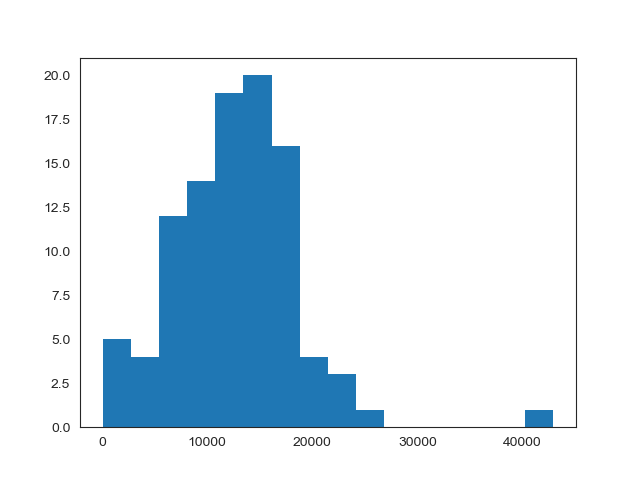

In [27]:
plt.figure()
h = plt.hist(bf_values[1:], bins='fd', linewidth=0)

In [273]:
fit = CellFit(gc, 'storm_inner')

In [275]:
d = cell_to_dict(gc)
d['r'] /= (1.5554007217841803 * 1.314602664567288)

In [276]:
fit.fit.objective(**d)

35.4864392633369

In [257]:
d

{'a0': 43.890236752549015,
 'a1': -0.570504181999443,
 'a2': 0.005518610784238978,
 'r': 4.2971128046533575,
 'xl': 28.78645236701025,
 'xr': 74.59177166516638}

In [265]:
gc.coords.xr

74.59177166516638

In [277]:
d1

{'a0': 43.97269929406656,
 'a1': -0.5732916747105762,
 'a2': 0.005539242296143547,
 'xl': 28.780508499992656,
 'xr': 74.60265619765232,
 'r': 4.285190365121568}

In [278]:
d1['r'] = d['r']

In [279]:
fit.fit.objective(**d1)

35.44381129449264

[(1894.2985826548559, 8.818860566356133), (1966.598235916937, 4.843353093461802), (1495.4152998775933, 6.349072522323167), (1660.9643615455584, 4.268160653878378), (2709.0734352552163, 9.249278609303582), (1698.449987254503, 2.010396414712934), (1259.4779390194176, 3.326229631005873), (4109.295976646306, 5.286262001059862), (1359.0182851858103, 1.6212511896343802), (1656.550064568301, 2.5019149067162485)]
(1550.8634724253557, 4.754706705232573)
51.752867832810665
63.776123254201735


<IPython.core.display.Javascript object>


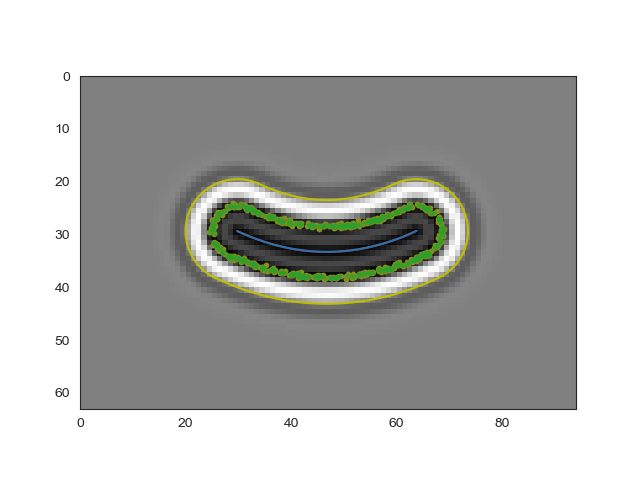

In [89]:
gt_cell = gt_sorted[30].copy()
m_cell = m_sorted[30].copy()

def transform_cells(gt_cell, m_cell):
    P = np.stack([m_cell.data.data_dict['storm_inner']['x'], m_cell.data.data_dict['storm_inner']['y']]).T
    Q = np.stack([gt_cell.data.data_dict['storm_inner']['x'], gt_cell.data.data_dict['storm_inner']['y']]).T

    x = np.linspace(m_cell.coords.xl, m_cell.coords.xr, num=1000, endpoint=True)
    T = np.stack((x, m_cell.coords.p(x))).T

    P_mean = np.mean(P, axis=0)
    Q_mean = np.mean(Q, axis=0)

    Pt = P - P_mean
    Qt = Q - Q_mean

    U = kabsch(Pt, Qt)

    Tt = T - P_mean
    Tr = np.dot(Tt, U)

    Pr = np.dot(Pt, U)
    Prt = Pr + Q_mean
    Trt = Tr + Q_mean

    xl = Trt.T[0].min()
    xr = Trt.T[0].max()
    r = m_cell.coords.r

    a0, a1, a2 = np.polyfit(Trt.T[0], Trt.T[1], 2)[::-1]

    d_m = {'a0': a0, 'a1': a1, 'a2': a2, 'xl': xl, 'xr':xr, 'r':r}
    
    return d_m

def get_value(gt_cell, m_cell, data_name):
    d_m = transform_cells(gt_cell, m_cell)
    d_g = cell_to_dict(gt_cell)
    
    if data_name == 'storm_inner':
        d_g['r'] /= (1.5554007217841803 * 1.314602664567288)
        d_m['r'] = d_g['r']

    fit = CellFit(gt_cell.copy(), data_name)

    val_m = fit.fit.objective(**d_m)
    val_g = fit.fit.objective(**d_g)

    return val_m, val_g

res = [get_value(g, m, 'brightfield') for g, m in zip(gt_sorted[100:110], m_sorted[100:])]
print(res)

print(get_value(gt_cell, m_cell, 'brightfield'))
print(x.max())

print(Trt.T[0].max())

plt.figure()
cp = CellPlot(gt_cell)
cp.imshow('brightfield')
cp.plot_outline(color='y')
cp.plot_midline()

plt.plot(Trt.T[0], Trt.T[1])
plt.plot(Prt.T[0], Prt.T[1], '.')
plt.plot(Q.T[0], Q.T[1], '.', alpha=0.5)


{'a0': 3.3816870583576786, 'a1': 1.279392740588898, 'a2': -0.013681010902580708, 'xl': 29.8090789513268, 'xr': 63.776123254201735, 'r': 4.791366595592367}
{'a0': 3.0929613940202465, 'a1': 1.2922012219595884, 'a2': -0.01381649221271373, 'r': 9.826640898398901, 'xl': 29.8266408983989, 'xr': 63.69935702244271}
27.84972210811761 28.0098923054791
51.752867832810665
63.776123254201735


<IPython.core.display.Javascript object>


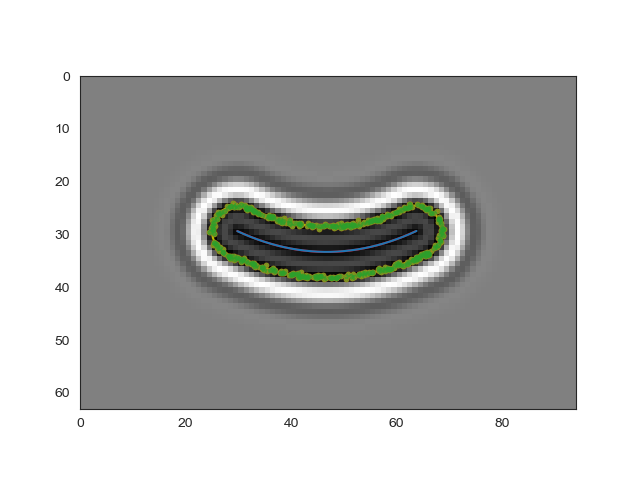

In [62]:
gt_cell = gt_sorted[30].copy()
m_cell = m_sorted[30].copy()


P = np.stack([m_cell.data.data_dict['storm_inner']['x'], m_cell.data.data_dict['storm_inner']['y']]).T
Q = np.stack([gt_cell.data.data_dict['storm_inner']['x'], gt_cell.data.data_dict['storm_inner']['y']]).T

x = np.linspace(m_cell.coords.xl, m_cell.coords.xr, num=1000, endpoint=True)
T = np.stack((x, m_cell.coords.p(x))).T

P_mean = np.mean(P, axis=0)
Q_mean = np.mean(Q, axis=0)

Pt = P - P_mean
Qt = Q - Q_mean

U = kabsch(Pt, Qt)

Tt = T - P_mean
Tr = np.dot(Tt, U)

Pr = np.dot(Pt, U)
Prt = Pr + Q_mean
Trt = Tr + Q_mean

xl = Trt.T[0].min()
xr = Trt.T[0].max()
r = m_cell.coords.r

a0, a1, a2 = np.polyfit(Trt.T[0], Trt.T[1], 2)[::-1]

d_m = {'a0': a0, 'a1': a1, 'a2': a2, 'xl': xl, 'xr':xr, 'r':r}
d_g = cell_to_dict(gt_cell)

print(d_m)
print(d_g)

d_g['r'] /= (1.5554007217841803 * 1.314602664567288)
d_m['r'] = d_g['r']

data_name = 'storm_inner'
fit = CellFit(gt_cell, data_name)

val_m = fit.fit.objective(**d_m)
val_g = fit.fit.objective(**d_g)

print(val_m, val_g)

print(x.max())

print(Trt.T[0].max())

plt.figure()
cp = CellPlot(gt_cell)
cp.imshow('brightfield')
cp.plot_outline(color='y')
cp.plot_midline()

plt.plot(Trt.T[0], Trt.T[1])
plt.plot(Prt.T[0], Prt.T[1], '.')
plt.plot(Q.T[0], Q.T[1], '.', alpha=0.5)


In [229]:
gc.length, mc.length

(46.288563170341796, 46.30952523703936)

<IPython.core.display.Javascript object>


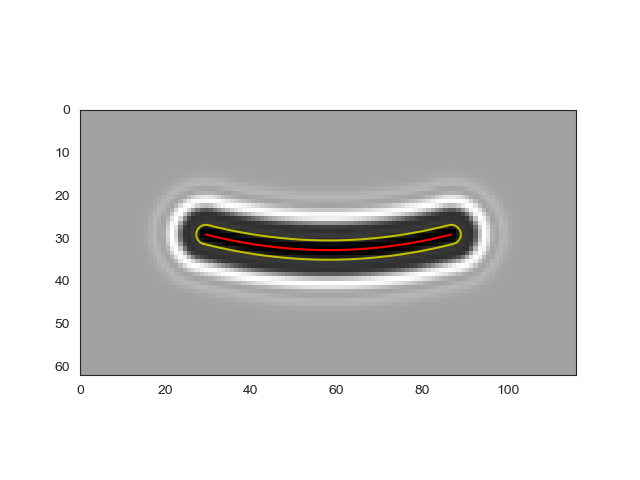

In [50]:
plt.figure()
cp = CellPlot(gc)
cp.imshow('brightfield')
cp.plot_outline(color='y')
cp.plot_midline()

<IPython.core.display.Javascript object>


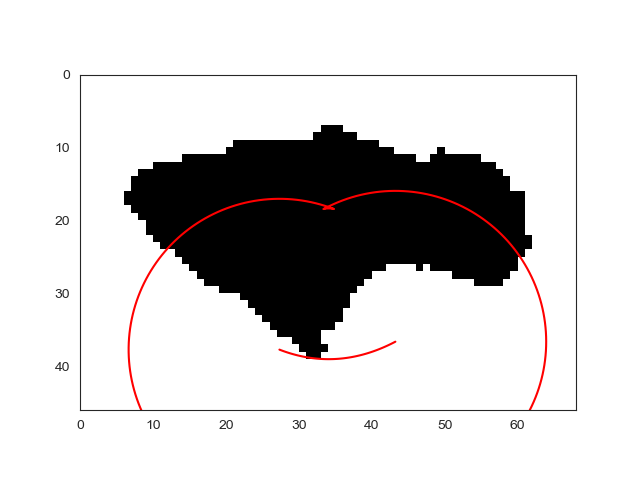

In [321]:
plt.figure()
cp = CellPlot(m_sorted[5152])
cp.imshow('binary')
cp.plot_outline()
cp.plot_midline()

In [122]:
np.polyfit(Trt.T[0], Trt.T[1], 2)

array([-4.25673165e-03,  3.82697850e-01,  2.11645145e+01])

In [124]:
gc.coords.coeff[::-1]

array([-4.18485091e-03,  3.74723456e-01,  2.13761125e+01])

In [43]:
u = kabsch(P, Q)

In [44]:
u

array([[ 0.99407171, -0.10872638],
       [ 0.10872638,  0.99407171]])

<IPython.core.display.Javascript object>


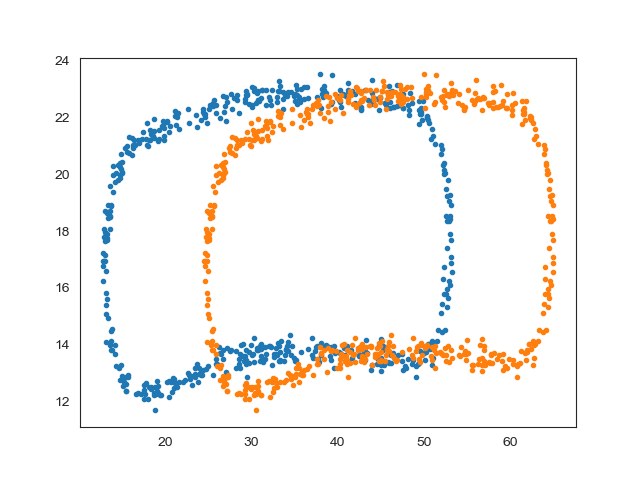

In [53]:
plt.figure()
plt.plot(P.T[0], P.T[1], '.')
plt.plot(Q.T[0], Q.T[1], '.')

In [56]:
Qp = Q - Q.mean(axis=0)
Pp = P - P.mean(axis=0)

<IPython.core.display.Javascript object>


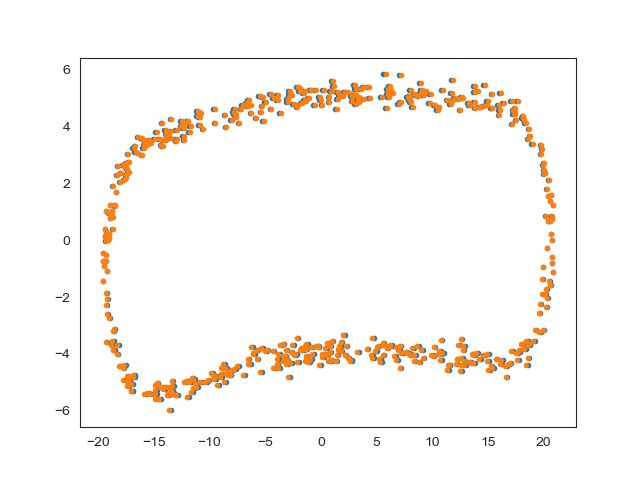

In [57]:
plt.figure()
plt.plot(Pp.T[0], Pp.T[1], '.')
plt.plot(Qp.T[0], Qp.T[1], '.')

In [61]:
u = kabsch(Pp, Qp)

In [80]:
P.shape, Q.shape

((555, 2), (555, 2))

In [87]:
from rmsd import kabsch_rmsd, kabsch_rotate

In [79]:
kabsch_rmsd

<function rmsd.calculate_rmsd.kabsch_rmsd(P, Q, translate=False)>

In [102]:
Q.mean(axis=0)

array([44.16412869, 29.19356291])

In [103]:
P.mean(axis=0)

array([32.33864166, 17.67876556])

<IPython.core.display.Javascript object>


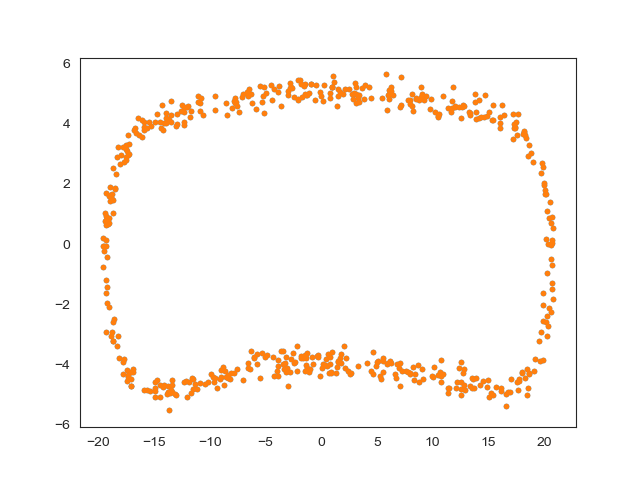

In [106]:
Qp = Q - Q.mean(axis=0)
Pp = P - P.mean(axis=0)

Pr = kabsch_rotate(Pp, Qp)

U = kabsch(Pp, Qp)

Qr = Qp#np.dot(Qp, U)
#Pr = Pp#np.dot(Pp, U)

plt.figure()
plt.plot(Pr.T[0], Pr.T[1], '.')
plt.plot(Qr.T[0], Qr.T[1], '.')

In [65]:
from rmsd.calculate_rmsd import quaternion_rmsd

In [71]:
P3 = np.column_stack((P, np.zeros(len(P))))
Q3 = np.column_stack((Q, np.zeros(len(Q))))

In [73]:
Q3.shape

(555, 3)

<IPython.core.display.Javascript object>


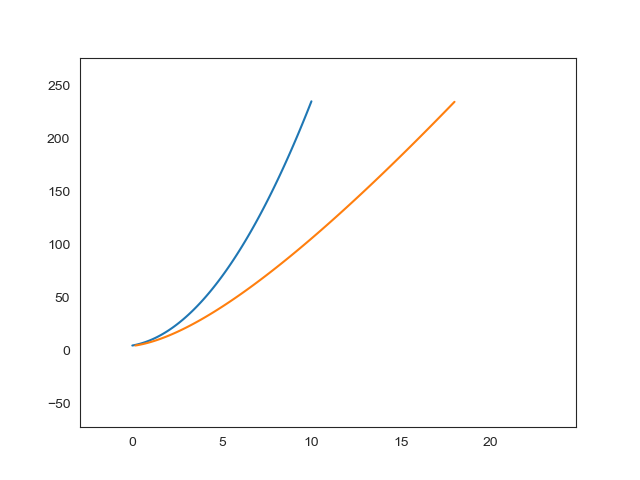

In [109]:
a = 2
b = 3
c = 5
x = np.linspace(0, 10, num=100)
y = a*x**2 + b*x + c

T = np.stack([x, y]).T
R = np.dot(T, U)

plt.figure()
plt.plot(T.T[0], T.T[1])
plt.plot(R.T[0], R.T[1])

plt.show()

In [108]:
T.shape

(100, 2)

In [72]:
R, T = quaternion_rmsd(P3, Q3)

TypeError: 'numpy.float64' object is not iterable

<IPython.core.display.Javascript object>


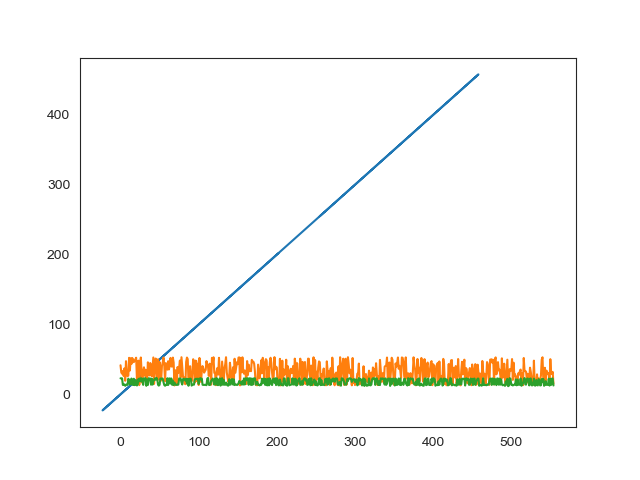

In [36]:
plt.figure()
plt.plot(gc.data.data_dict['storm_inner']['intensity'], gc.data.data_dict['storm_inner']['intensity'])

In [37]:
gc.data.data_dict['storm_inner']['intensity'].min()

STORMTable(-23, dtype=int64)

In [ ]:
apply